### Read and Display Images in OpenCV

In [1]:
#%pip install opencv-python 
import cv2
cv2.__version__

'4.6.0'

In [2]:
#Required libraries
import numpy as np                    #for numerical computation
import matplotlib.pyplot as plt       #for data visualization

In [3]:
#Read image
img = cv2.imread('sample_image_03.jpg')

In [4]:
img.shape

(383, 578, 3)

In [5]:
#Display the image w/ OpenCV
cv2.imshow( 'Image',img)
cv2.waitKey(6000)
cv2.destroyWindow('Image')

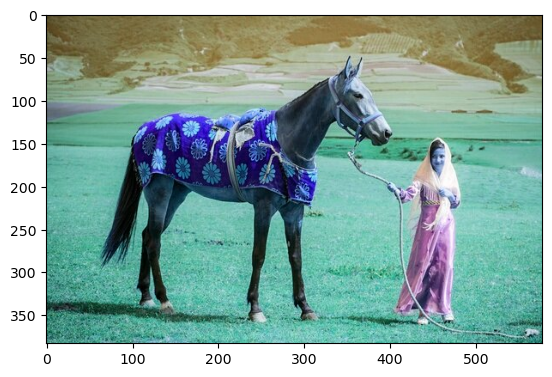

In [6]:
#Display the image with Matplotlib
plt.imshow(img)

#Note: OpenCV reads and displays an image as BGR format instead of RGB color format
#Note: In the above image note that x-axis points positive to 
#      the right and y-axis points positive downwards.

### Object Detection 

You only look once (YOLOv3) is a state-of-the-art, real-time object detection system:

https://pjreddie.com/darknet/yolo/

we will see how to setup object detection with YOLOv3-tiny and OpenCV on images and video.

In [7]:
with open('coco_names.txt') as file:
    labels = file.read().split('\n')   

In [8]:
labels

['ï»¿person',
 'bicycle',
 'car',
 'motorbike',
 'aeroplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'sofa',
 'pottedplant',
 'bed',
 'diningtable',
 'toilet',
 'tvmonitor',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

In [9]:
model = cv2.dnn.readNet('yolo-tiny.cfg', 'yolov3-tiny.weights')

In [10]:
#CNN input size
net_wh = 320

In [11]:
#Preprocess image
processed_img = cv2.dnn.blobFromImage(img, 1 / 255, (net_wh, net_wh), mean = [0, 0, 0], swapRB = True, crop = False)

In [12]:
processed_img.shape

(1, 3, 320, 320)

In [13]:
#Input image to model
model.setInput(processed_img)

In [14]:
#Extract networl's layer names
layer_names = model.getLayerNames()

In [15]:

model.getUnconnectedOutLayers()

array([36, 48])

In [16]:
# determine only the *output* layer names that we need from YOLOv3-tiny
output_names = [layer_names[i - 1] for i in model.getUnconnectedOutLayers()]

In [17]:
output_names

['yolo_16', 'yolo_23']

In [18]:
outputs = model.forward(output_names)

In [19]:
def obj_detection(outputs, img, obj_threshold = 0.4):
    input_h, input_w, _ = img.shape
    # initialize our lists of detected bounding boxes, confidences, label_ids and  confidences
    boxes = []
    label_ids = []
    confs = []
    
    # loop over each of the layer outputs
    for output in outputs:
        for row in output:
            
            # extract the class_ids and confidence (i.e., probability) of the current object detection
            probs = row[5: ]
            label_id = np.argmax(probs)
            confidence = probs[label_id]
            if confidence > obj_threshold:
                
                #width and height of detection box
                w, h = int(row[2] * input_w), int(row[3] * input_h)
                
                #center of detection box
                cx, cy = int(row[0] * input_w), int(row[1] * input_h)
                
                #x and y of left upper corner of detection box
                x, y = int(cx - w / 2), int(cy - h / 2)
                
                #Append box
                boxes.append([cx, cy, w, h])
                
                #Append label id
                label_ids.append(label_id)
                
                #Append confidence
                confs.append(np.round(confidence, decimals = 4))
    
    return(boxes, label_ids, confs)

In [20]:
obj_detection(outputs, img, obj_threshold = 0.4)

([[217, 220, 316, 291], [440, 248, 76, 235], [443, 249, 97, 215]],
 [17, 0, 0],
 [0.6975, 0.5831, 0.9341])

In [21]:
cv2.dnn.NMSBoxes(obj_detection(outputs, img)[0], obj_detection(outputs, img)[2], 0.4, 0.8)

array([2, 0, 1])

In [23]:
#Complete object detection function
def obj_detection(outputs, img, obj_threshold = 0.4, nms_threshold = 0.8):
    input_h, input_w, _ = img.shape
    boxes = []
    label_ids = []
    confs = []
    
    for output in outputs:
        for row in output:
            probs = row[5: ]
            label_id = np.argmax(probs)
            confidence = probs[label_id]
            if confidence > obj_threshold:
                
                #width and height of detection box
                w, h = int(row[2] * input_w), int(row[3] * input_h)
                
                #center of detection box
                cx, cy = int(row[0] * input_w), int(row[1] * input_h)
                
                #x and y of left upper corner of detection box
                x, y = int(cx - w / 2), int(cy - h / 2)
                
                #Append box
                boxes.append([x, y, w, h])
                
                #Append label id
                label_ids.append(label_id)
                
                #Append confidence
                confs.append(np.round(confidence, decimals = 4))
    
    indices = cv2.dnn.NMSBoxes(boxes, confs, obj_threshold, nms_threshold)
    for i in indices:
        box = boxes[i]
        # extract the bounding box coordinates
        x, y, w, h = box[0], box[1], box[2], box[3]
        cv2.rectangle(img, (x, y), (x + w, y + h), (178, 255, 102), 1)
        text = "{}: {:.4f}".format(labels[label_ids[i]], confs[i])
        cv2.putText(img, f'{labels[label_ids[i]].upper()}{": "}{confs[i] * 100}{"%"}',
                    (x, y - 5), cv2.FONT_HERSHEY_PLAIN, 1, (178, 255, 102), 2)
        #cv2.putText(img, text, (x, y - 5), cv2.FONT_HERSHEY_PLAIN, 1, (178, 255, 102), 2)
        print(labels[label_ids[i]].upper() + ": " + "{0:.2f}".format(confs[i] * 100) + "%")
      

In [24]:
 #cv2.imwrite("example.png", img)  

In [25]:
obj_detection(outputs, img, obj_threshold = 0.4, nms_threshold = 0.8)


Ï»¿PERSON: 93.41%
HORSE: 69.75%
Ï»¿PERSON: 58.31%


In [26]:
#Display the image w/ OpenCV
cv2.imshow('Image', img)
#cv2.waitKey(6000)
#cv2.destroyWindow('Image')

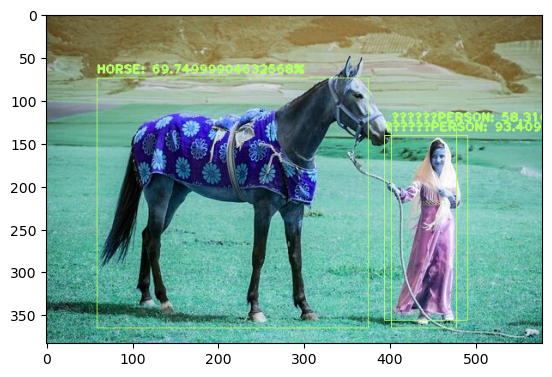

In [27]:
plt.imshow(img)

In [28]:
#Read image
img1 = cv2.imread('sample_image_04.jpg')

#Preprocess image
processed_img = cv2.dnn.blobFromImage(img1, 
                                      scalefactor = 1 / 255, 
                                      size = (net_wh, net_wh), 
                                      mean = [0, 0, 0], 
                                      swapRB = True, crop = False)

#Run prediction
model.setInput(processed_img)
output_names = [layer_names[i - 1] for i in model.getUnconnectedOutLayers()]
outputs = model.forward(output_names)
obj_detection(outputs, img1, obj_threshold = 0.4, nms_threshold = 0.8)

#Display the image w/ OpenCV
cv2.imshow('Image', img1)
#cv2.waitKey(6000)
#cv2.destroyWindow('Image')

MOTORBIKE: 66.71%


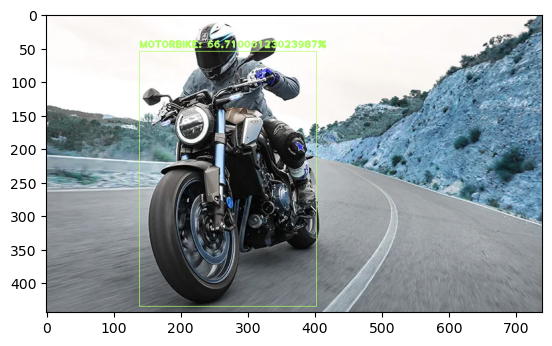

In [29]:
plt.imshow(img1)

###  Video File

In [ ]:
obj_threshold = 0.3
nms_threshold = 0.6

cap = cv2.VideoCapture('sample_video.mp4')
while True:
    #Input frame
    ret, frame = cap.read()
    
    #Preprocess each frame
    processed_img = cv2.dnn.blobFromImage(frame, 1 / 255, (net_wh, net_wh), [0, 0, 0], 1, crop = False)
        
    #Run the prediction
    model.setInput(processed_img)
    layer_names = model.getLayerNames()
    output_names = [layer_names[i - 1] for i in model.getUnconnectedOutLayers()]
    outputs = model.forward(output_names)
    
    #Object detection
    obj_detection(outputs, frame, obj_threshold, nms_threshold)
    
    cv2.imshow('Camera', frame)
    
    c = cv2.waitKey(1)
    if c == 27:
        break
cap.release()
cv2.destroyAllWindows()

CAR: 42.16%
CAR: 39.62%
CAR: 34.27%
CAR: 41.39%
CAR: 31.44%
CAR: 64.50%
CAR: 42.16%
CAR: 48.31%
CAR: 32.97%
CAR: 58.30%
CAR: 54.64%
CAR: 67.54%
CAR: 59.59%
CAR: 51.02%
CAR: 49.79%
CAR: 43.08%
CAR: 30.11%
CAR: 34.90%
CAR: 31.55%
CAR: 31.08%
CAR: 40.42%
CAR: 34.34%
CAR: 47.81%
CAR: 38.24%
CAR: 33.21%
CAR: 44.91%
CAR: 32.53%
CAR: 30.70%
CAR: 59.79%
CAR: 49.54%
CAR: 32.44%
CAR: 31.97%
CAR: 59.95%
CAR: 47.27%
Ï»¿PERSON: 33.42%
CAR: 40.24%
Ï»¿PERSON: 38.58%
CAR: 75.44%
CAR: 52.55%
CAR: 34.65%
CAR: 30.11%
CAR: 84.63%
CAR: 59.88%
CAR: 39.66%
CAR: 36.65%
CAR: 60.98%
CAR: 41.50%
CAR: 66.27%
CAR: 62.10%
CAR: 49.34%
CAR: 35.32%
Ï»¿PERSON: 33.59%
Ï»¿PERSON: 30.51%
CAR: 74.00%
CAR: 72.79%
CAR: 64.77%
CAR: 76.85%
CAR: 76.22%
CAR: 65.53%
CAR: 84.49%
CAR: 83.79%
CAR: 73.02%
CAR: 84.39%
CAR: 83.72%
CAR: 62.18%
CAR: 77.83%
CAR: 59.67%
CAR: 45.94%
CAR: 77.45%
CAR: 77.15%
CAR: 57.19%
CAR: 36.64%
CAR: 81.02%
CAR: 62.95%
CAR: 56.79%
CAR: 81.52%
CAR: 61.00%
CAR: 58.91%
CAR: 39.57%
CAR: 82.36%
CAR: 76.45%
CAR: